# $\mathbb{Z}_{2}$-symmetric singlet extension of the Standard Model ($\mathbb{Z}_{2}$-RxSM)

In [ ]:
from Higgs.tools.ImplementationUtils import implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
import Higgs.bounds as HB
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc("axes",labelsize="large")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600

import os
os.chdir('/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections/')
# os.getcwd()

## Vizualizing the likelihood

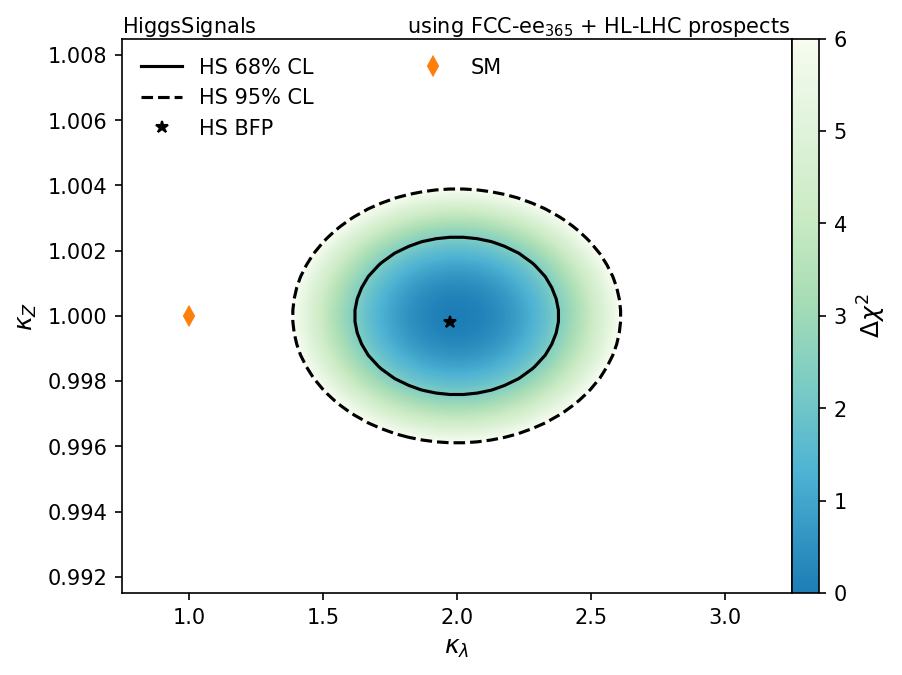

0

In [3]:
pred = HP.Predictions()
h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(125)

coups = HP.scaledSMlikeEffCouplings(1)
HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")

# Copy the measurement json files to a common directory
hsdataset_dir = "hsdataset/h125"
os.system(f"mkdir future_projections_data")
os.system(f"cp {hsdataset_dir}/EffCouplings_FCCee365_FCCeeComb_1500.json future_projections_data/")
os.system(f"cp {hsdataset_dir}/EffLamHL-LHC_LHC13_LHCComb_6000.json future_projections_data/")
signals = HS.Signals("future_projections_data")
chisqSM = signals(pred)


def getChisq(kappa_Lam, kappa_ZZ):
    coups.lam = kappa_Lam
    coups.ZZ  = kappa_ZZ
    HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    return signals(pred)


test = np.frompyfunc(getChisq, 2, 1)
wgt = 5.
c_Lam = np.linspace(2 - wgt*0.25, 2 + wgt*0.25)
# c_Lam = np.linspace(2 - wgt*50./100., 2 + wgt*50./100.)
c_ZZ  = np.linspace(1 - wgt*0.17/100., 1 + wgt*0.17/100.)
chisq = test(*np.meshgrid(c_Lam, c_ZZ))
chisq = np.array(chisq, dtype="float64")

fig, ax = plt.subplots()
chisqPlot(
    fig,
    ax,
    c_Lam,
    c_ZZ,
    chisq,
    experiment=r"FCC-ee$_{365}$ + HL-LHC",
    description="prospects",
    # luminosity=meas_lam.luminosity(),
)
ax.plot(1, 1, c="tab:orange", marker="d", label="SM", ls="none")
ax.legend(loc="upper center", frameon=False)
ax.set_xlabel(r"$\kappa_{\lambda}$")
ax.set_ylabel(r"$\kappa_Z$")
plt.show()

os.system("rm -rf future_projections_data")

## Test with full HSDataset

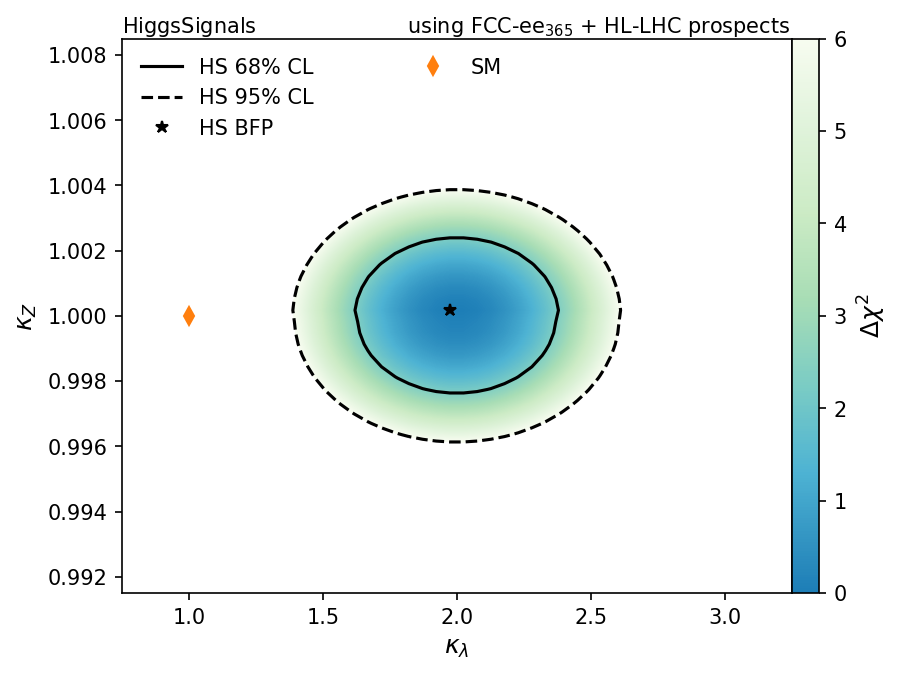

0

In [4]:
pred = HP.Predictions()
# bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
signals = HS.Signals('hsdataset') # load HS dataset

h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(125)

coups = HP.scaledSMlikeEffCouplings(1)
HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")

chisqSM = signals(pred)


def getChisq(kappa_Lam, kappa_ZZ):
    coups.lam = kappa_Lam
    coups.ZZ  = kappa_ZZ
    HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    return signals(pred)


test = np.frompyfunc(getChisq, 2, 1)
wgt = 5.
c_Lam = np.linspace(2 - wgt*0.25, 2 + wgt*0.25)
# c_Lam = np.linspace(2 - wgt*50./100., 2 + wgt*50./100.)
c_ZZ  = np.linspace(1 - wgt*0.17/100., 1 + wgt*0.17/100.)
chisq = test(*np.meshgrid(c_Lam, c_ZZ))
chisq = np.array(chisq, dtype="float64")

fig, ax = plt.subplots()
chisqPlot(
    fig,
    ax,
    c_Lam,
    c_ZZ,
    chisq,
    experiment=r"FCC-ee$_{365}$ + HL-LHC",
    description="prospects",
    # luminosity=meas_lam.luminosity(),
)
ax.plot(1, 1, c="tab:orange", marker="d", label="SM", ls="none")
ax.legend(loc="upper center", frameon=False)
ax.set_xlabel(r"$\kappa_{\lambda}$")
ax.set_ylabel(r"$\kappa_Z$")
plt.show()

os.system("rm -rf future_projections_data")

## Likelihood calculator

In [5]:
pred = HP.Predictions()
# bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
signals = HS.Signals('hsdataset') # load HS dataset

h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(125)

coups = HP.scaledSMlikeEffCouplings(1)
HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")

chisqSM = signals(pred)


def getChisq(kappaLam2L, kappaSingleHiggs2L, mS, signals):

    # S = pred.addParticle(HP.NeutralScalar("S", "even"))
    # S.setMass(mS)
    # HP.effectiveCouplingInput(S, NeutralEffectiveCouplings(), )

    for attr in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg']:
        setattr(coups, attr, kappaSingleHiggs2L)
    coups.lam = kappaLam2L
    HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    return signals(pred)

## Plotting function

In [6]:
from scipy import interpolate
import scipy.stats 
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

#### Useful auxiliary statistics functions

In [7]:
def confidence_level(nsigma):
    r"""Return the confidence level corresponding to a number of sigmas,
    i.e. the probability contained in the normal distribution between $-n\sigma$
    and $+n\sigma$.

    Example: `confidence_level(1)` returns approximately 0.68."""
    return (scipy.stats.norm.cdf(nsigma)-0.5)*2

def delta_chi2(nsigma, dof):
    r"""Compute the $\Delta\chi^2$ for `dof` degrees of freedom corresponding
    to `nsigma` Gaussian standard deviations.

    Example: For `dof=2` and `nsigma=1`, the result is roughly 2.3."""
    if dof == 1:
        # that's trivial
        return nsigma**2
    chi2_ndof = scipy.stats.chi2(dof)
    cl_nsigma = confidence_level(nsigma)
    return chi2_ndof.ppf(cl_nsigma)

def chi2_prob(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chi2_ndof = scipy.stats.chi2(dof)
    return 1 - chi2_ndof.cdf(chi2)

def chi2_prob_sigma(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chisq_probability = 1 - chi2_prob(chi2, dof)
    print(chisq_probability)
    chi2_1D = scipy.stats.chi2(1)
    return np.sqrt(chi2_1D.ppf(chisq_probability))

# print(delta_chi2(nsigma=1, dof=2))
# print(chi2_prob(6.180074, 2))

# chi2_1D = scipy.stats.chi2(1)
# print(chi2_1D.ppf(0.5))
chi2_prob_sigma(6.18,2)
chi2_prob_sigma(10.423363,9)

chi2_prob_sigma(6.8, 2)
# delta_chi2(1, 9)

0.9544980455953784
0.6826894804456776
0.9666267300396739


np.float64(2.1275637558787523)

In [8]:
# main plotting function
def plot_Z2_RxSM_bounds(data_file, 
                        plot_dir, 
                        signals, 
                        k_lambda_exp_error=0.25, 
                        zoom=False, 
                        full=False, 
                        zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                        zoom_range_y=(0.0, 0.01),
                        modified_central=False,
                        ndof=None):
    

    df = pd.read_csv(data_file + ".csv") if not full else pd.read_csv(data_file + "_full_set.csv")

    kappaLam2L = df['kappaLam2L']
    if not full:
        kappaSingleHiggs2L = df['kappaSingleHiggs2L']
        chisq = np.array([getChisq(row['kappaLam2L'], 1-row['kappaSingleHiggs2L'], row["mS"], signals) for _, row in df.iterrows()])
    else:
        kappaSingleHiggs2L = 1 - df['kappaSingleHiggs2L']
        chisq = np.array([getChisq(row['kappaLam2L'], row['kappaSingleHiggs2L'], row["mS"], signals) for _, row in df.iterrows()])
    # In the smaller sample, the value of the last 2 columns was (1-k)
    
    n_pts = df.shape[0]

    chisq_true = getChisq(2, 1, np.inf, signals)
    if modified_central: chisq_true = getChisq(*modified_central, np.inf, signals)
    chisq = chisq - chisq_true
    # y = [z if z < 12.001 else 12.001 for z in chisq]
    y = [z for z in chisq]
    df['col'] = y

    xscale = np.max(kappaLam2L) - np.min(kappaLam2L)
    yscale = np.max(kappaSingleHiggs2L) - np.min(kappaSingleHiggs2L)
    scale = np.array([xscale, yscale])

    mat = np.array([
        kappaLam2L.to_numpy(),
        kappaSingleHiggs2L.to_numpy(),
        df['col'].to_numpy()]).T
    
    grid_points = 300
    x = np.linspace(2 - 10*(2 - zoom_range_x[0]), 2 + 10*(zoom_range_x[1] - 2), grid_points)
    y = np.linspace(-0.02, 0.02, grid_points)
    X, Y = np.meshgrid(x, y)

    Z = np.full((grid_points, grid_points), np.inf)
    for i in range(grid_points):
        for j in range(grid_points):
            Z[i,j] = getChisq(x[i], 1-y[j], np.inf, signals)

    Z = Z - chisq_true
    Z = Z.T

    fig, ax = plt.subplots(
        figsize=(4.5, 4.),
        constrained_layout=True)

    # Rescaling colormap to avoid too-light points
    color_map = mpl.colormaps['GnBu_r']
    color_map = ListedColormap(color_map(np.linspace(0.0, 0.92, 256)))

    sc = ax.scatter(
        kappaLam2L,
        kappaSingleHiggs2L,
        c=df['col'],
        s=0.4,
        cmap=color_map,
        # vmin=,
        vmax=12.,
        rasterized=True)

    if zoom==False:
        # ax.set_xlim(np.min(kappaLam2L), np.max(kappaLam2L))
        ax.set_xlim(0, np.max(kappaLam2L))
        ax.set_ylim(np.min(kappaSingleHiggs2L)-0.005, np.max(kappaSingleHiggs2L))
    else:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\Delta\chi^2$",
        ticks=np.arange(0, 12.1, 1),
        pad=0,
        fraction=0.1,
        location='right',
        aspect=40,
        extend='max',
    )
    clb.ax.minorticks_on()

    if not ndof:
        if modified_central: ndof=1
        else: ndof=2
    print(ndof)
    levels_123sig = [delta_chi2(n_sigma, dof=ndof) for n_sigma in range(1, 3+1)]
    print(levels_123sig)

    ax.contour(
        X,
        Y,
        Z,
        levels=levels_123sig,
        colors="black",
        linestyles=["-", "--", ":"],
    )

 

    bfp_index = np.argmin(chisq)
    bfp_chisq = np.min(chisq)
    bfp = np.array([kappaLam2L[bfp_index], kappaSingleHiggs2L[bfp_index]])
    if modified_central: 
        plotted_point = list(modified_central)
        plotted_point[1] = 1 - plotted_point[1]
    else: plotted_point = bfp

    ax.plot(
        *plotted_point,
        marker="*", ls="none", c="r")
    print(f"Best scan point: (k_Lamb = {bfp[0]:.10g}, (1 - k_Z ) = {bfp[1]:.10g}), with chisq = {bfp_chisq:.3g}")
    print(f"Best scan point row: {bfp_index+2} out of {len(chisq)}")
    print(f"Best scan point model parameters: muS={df["muS"][bfp_index]}, lamS={df["lamS"][bfp_index]}, lamSH={df["lamSH"][bfp_index]}")

    if modified_central:
        bfp_legend_label = "Central values"+"\n"+f"($\kappa_{{\lambda}}={modified_central[0]:.3g}$, $1-\kappa_{{Z}}={1-modified_central[1]:.3g}$)"
        
    else:
        bfp_legend_label = fr"HS BFP ($\Delta\chi^2={bfp_chisq:.3g}$)"+"\n"+f"($\kappa_{{\lambda}}={bfp[0]:.3g}$, $\kappa_{{Z}}-1={bfp[1]:.3g}$)"
    percent = "\%" if plt.rcParams["text.usetex"] else "%"
    hsLegend = ax.legend(
        handles=[
            Line2D([0], [0], color="k", ls="none", marker="*", c="r", 
                   label=bfp_legend_label),
            Line2D([0], [0], color="k", ls="-",  label=f"HS 68.3{percent} CL"),
            Line2D([0], [0], color="k", ls="--", label=f"HS 95.4{percent} CL"),
            Line2D([0], [0], color="k", ls=":",  label=f"HS 99.7{percent} CL"),
        ],
        loc="upper right",
        frameon=False,
        prop={'size': 7}
    )
    ax.add_artist(hsLegend)

    # majorLocator = MultipleLocator(0.01)
    # minorLocator = MultipleLocator(0.001)
    # ax.yaxis.set_major_locator(majorLocator)
    # ax.yaxis.set_minor_locator(minorLocator)
    # ax.tick_params(
    #     axis="y",
    #     direction="in",
    #     which="both",
    #     right=True)

    # majorLocator = MultipleLocator(1.0)
    # minorLocator = MultipleLocator(0.2)
    # ax.xaxis.set_major_locator(majorLocator)
    # ax.xaxis.set_minor_locator(minorLocator)
    # ax.tick_params(
    #     axis="x",
    #     direction="in",
    #     which="both",
    #     top=True)

    # ax.set_xlabel(r'$\kappa_{\lambda}^{(2)}$')
    ax.set_xlabel(r'$\kappa_{\lambda}$')
    # ax.set_ylabel(r'$1 - \kappa_{Z}^{(2)}$')
    ax.set_ylabel(r'$1 - \kappa_{Z}$')

    if modified_central:
        chisq_SM = getChisq(1, 1, np.inf, signals) - chisq_true
        lower_text = fr"$\chi^{2}_{{\text{{SM}}}} = {{{chisq_SM:.2g}}}$ ({chi2_prob_sigma(chisq_SM, ndof):.2g}$\sigma$)"+'\n'+ \
                     f'{n_pts} Points'+'\n'+ \
                     r'$\kappa_{Z}=\kappa_{Z\gamma}=\kappa_{g}=\kappa_{\gamma}=\kappa_{f}$'+'\n'+ \
                     r'$\mathbb{Z}_{2}$-symmetric RxSM'
        
    else:
        lower_text = f'{n_pts} Points'+'\n'+ \
                     fr'$\kappa^{{\text{{Exp}}}}_{{\lambda}}(\text{{HL-LHC}})=2\pm{{{k_lambda_exp_error:.2g}}}$'+'\n'+ \
                     r'$\kappa_{Z}=\kappa_{W}=\kappa_{Z\gamma}=\kappa_{g}=\kappa_{\gamma}=\kappa_{f}$'+'\n'+ \
                     r'$\mathbb{Z}_{2}$-symmetric RxSM'
    ax.text(
        0.97,
        0.20,
        lower_text,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=8
        )

    ax.text(
        0,
        1,
        r"$\mathrm{HiggsSignals}$",
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    # ax.set_yscale('log')

    plot_name = f'Z2_RxSM_results_klam_err_{k_lambda_exp_error:.2g}'
    if modified_central: plot_name = f'Z2_RxSM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    if full: plot_name = plot_name + "_full"
    if zoom: plot_name = plot_name + "_zoom"
    plt.savefig(f'{plot_dir}/{plot_name}'+".pdf")

<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:129: SyntaxWarning: invalid escape sequence '\l'
<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:132: SyntaxWarning: invalid escape sequence '\k'
<>:132: SyntaxWarning: invalid escape sequence '\l'
<>:132: SyntaxWarning: invalid escape sequence '\k'
<>:133: SyntaxWarning: invalid escape sequence '\%'
<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:129: SyntaxWarning: invalid escape sequence '\l'
<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:132: SyntaxWarning: invalid escape sequence '\k'
<>:132: SyntaxWarning: invalid escape sequence '\l'
<>:132: SyntaxWarning: invalid escape sequence '\k'
<>:133: SyntaxWarning: invalid escape sequence '\%'
/jwd/tmp/ipykernel_1546/2550546605.py:129: SyntaxWarning: invalid escape sequence '\k'
  bfp_legend_label = "Central values"+"\n"+f"($\kappa_{{\lambda}}={modified_central[0]:.3g}$, $1-\kappa_{{Z}}={1-modified_central[1]:.3g}$)"
/jwd/tmp/ipykernel_1546/2550546605.py:129: S

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.842365424, (1 - k_Z ) = 0.002885520348), with chisq = 3.45
Best scan point row: 15510 out of 18870
Best scan point model parameters: muS=1832.4270135440772, lamS=1.299542571026544, lamSH=20.213067307058065


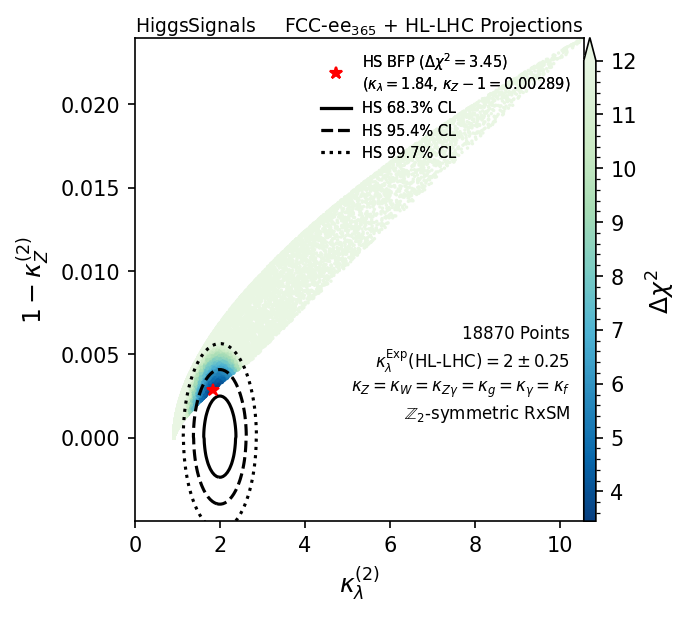

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan"
plot_dir = "plots"
plot_Z2_RxSM_bounds(data_file, plot_dir, signals)

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.842365424, (1 - k_Z ) = 0.002885520348), with chisq = 3.45
Best scan point row: 15510 out of 18870
Best scan point model parameters: muS=1832.4270135440772, lamS=1.299542571026544, lamSH=20.213067307058065


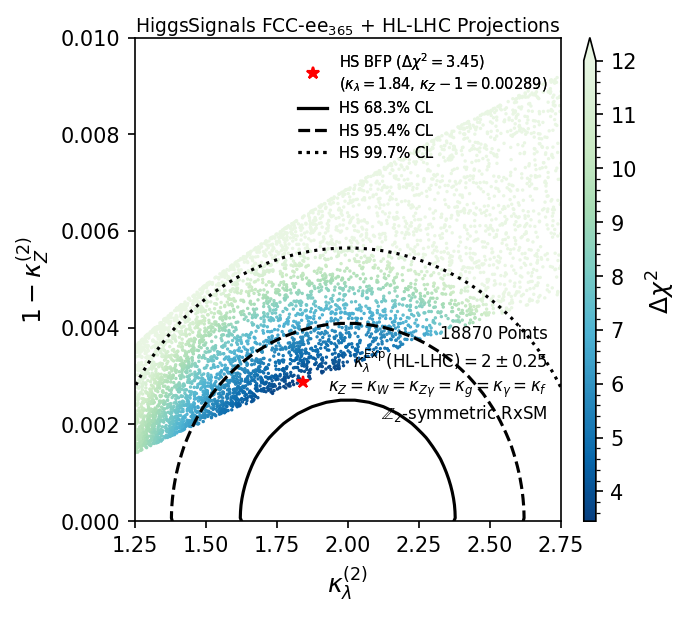

In [10]:
plot_Z2_RxSM_bounds(data_file, plot_dir, signals, zoom=True)

## Full dataset

[2025-01-04 20:10:23.442] [HiggsPredictions] [warning] Di-higgs non resonant ggF production cross section is not computed. No further warning will be printed.
[2025-01-04 20:10:23.442] [HiggsPredictions] [warning] Di-higgs non resonant VBF production cross section is not computed. No further warning will be printed.
2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.838306494, (1 - k_Z ) = 0.002870277465), with chisq = 3.44
Best scan point row: 105034 out of 203144
Best scan point model parameters: muS=1840.494832515644, lamS=7.287573362531175, lamSH=20.231663128151084


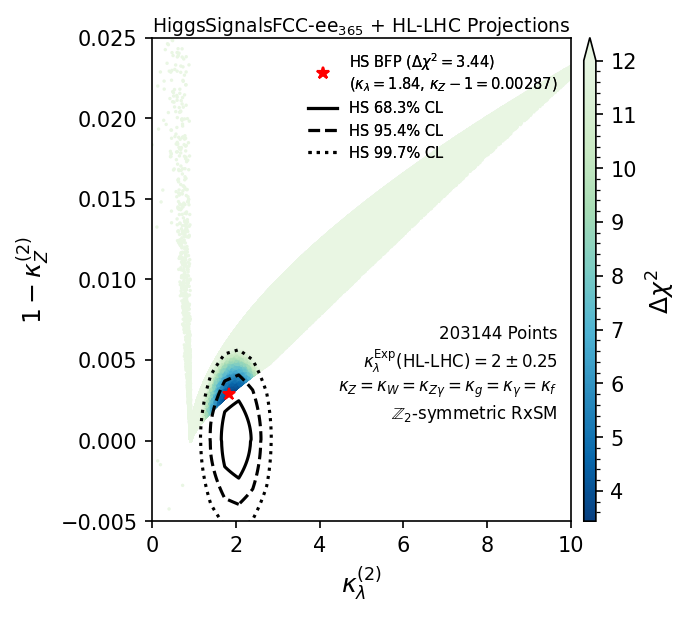

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan_fixed"
plot_Z2_RxSM_bounds(data_file, plot_dir, signals, full=True, zoom=True, zoom_range_x=(0, 10), zoom_range_y=(-0.005, 0.025))

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.838306494, (1 - k_Z ) = 0.002870277465), with chisq = 3.44
Best scan point row: 105034 out of 203144
Best scan point model parameters: muS=1840.494832515644, lamS=7.287573362531175, lamSH=20.231663128151084


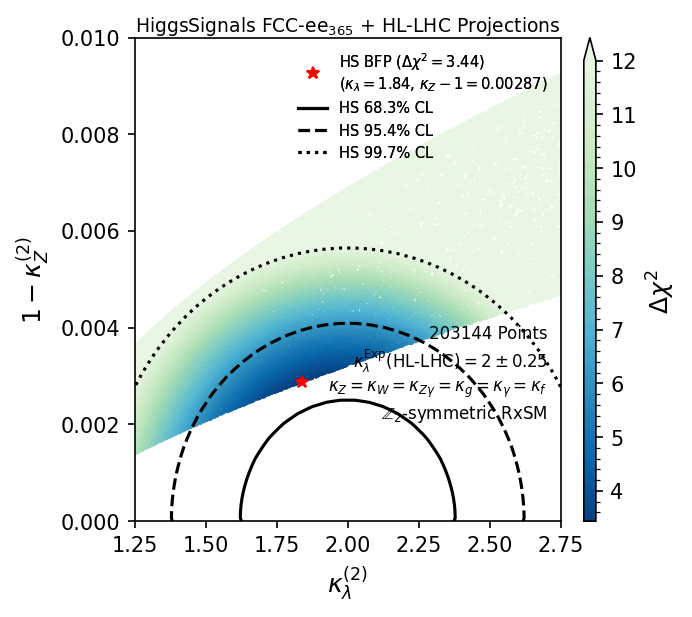

In [12]:
plot_Z2_RxSM_bounds(data_file, plot_dir, signals, full=True, zoom=True)

## Tests for different HL-LHC $\kappa_{\lambda}$ pseudo-uncertainties

#### Function for modification the pseudo-uncertainty on $\kappa_{\lambda}$

In [64]:
# os.chdir("/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections")

def modify_kappa_lambda_error(k_lambda_exp_error):
    
    os.system("mkdir modified_measurements")
    os.system("cp -r hsdataset/* modified_measurements/")
    os.chdir("modified_measurements/h125")
    os.system("rm EffLamHL-LHC_LHC13_LHCComb_6000.json")

    bins = {
        "effLam": {
            "coupling": "effLam",
            "obsCoupling": [2 - k_lambda_exp_error, 2, 2 + k_lambda_exp_error],
            # "obsCoupling": [2 - 50./100., 2, 2 + 50./100.],
            "process": {"channels": [[p, "WW"] for p in ("H", "vbfH")]},
        },
    }

    measFile_lam = implementMeasurement(
        "1905.03764",
        "HL-LHC Projection",
        bins,
        # corrMatExp=corrMat,
        prefix="EffLamHL-LHC",
        referenceMass=125.38,
        massResolution=0.15 * 125,  # Change!
        idSuffix=1,
        experiment="LHCComb",
        collider="LHC13",
        luminosity=6000
    )

    os.chdir("../..")


#### Modification and plotting

Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 2, (k_Z - 1) = 0.00329), with chisq = 5.16
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.99, (k_Z - 1) = 0.00321), with chisq = 4.98
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.97, (k_Z - 1) = 0.00316), with chisq = 4.81
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.84, (k_Z - 1) = 0.00289), with chisq = 4.33
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.39, (k_Z - 1) = 0.00179), with chisq = 2.99
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 0.984, (k_Z - 1) = 0.000445), with chisq = 1.12


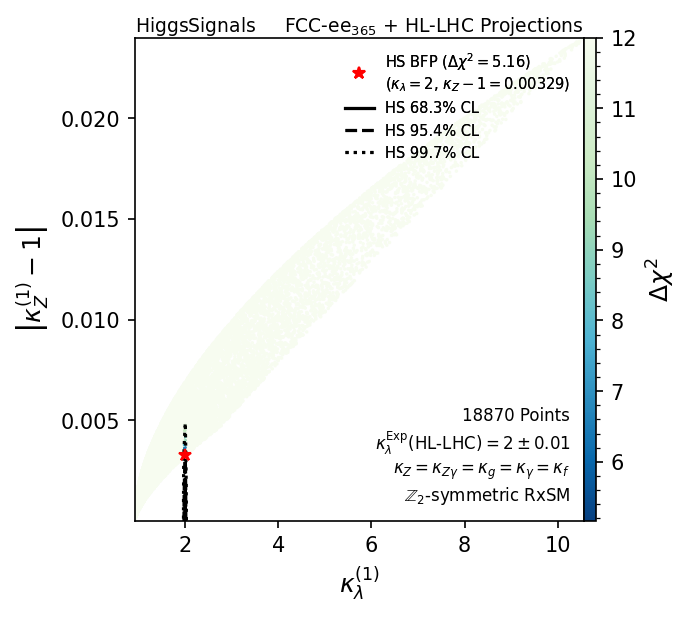

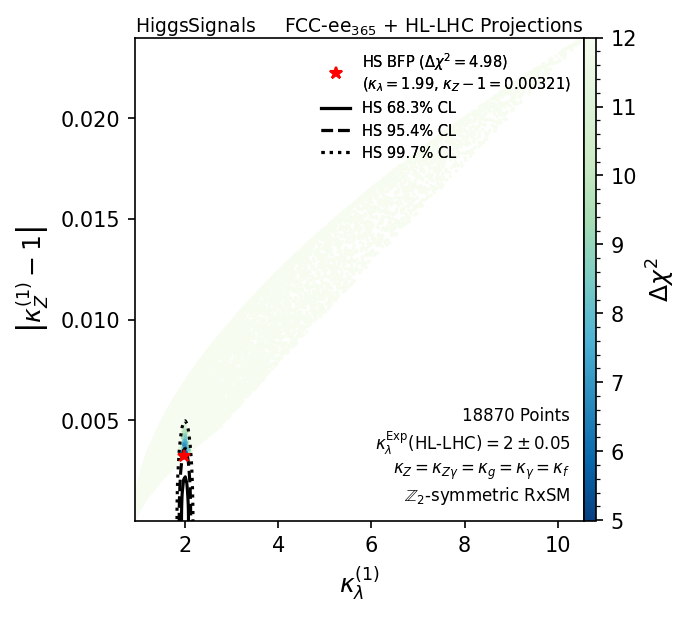

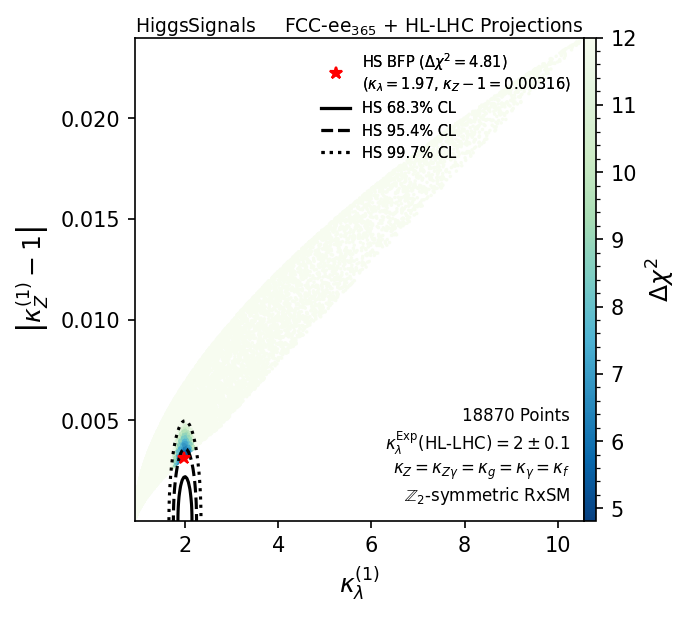

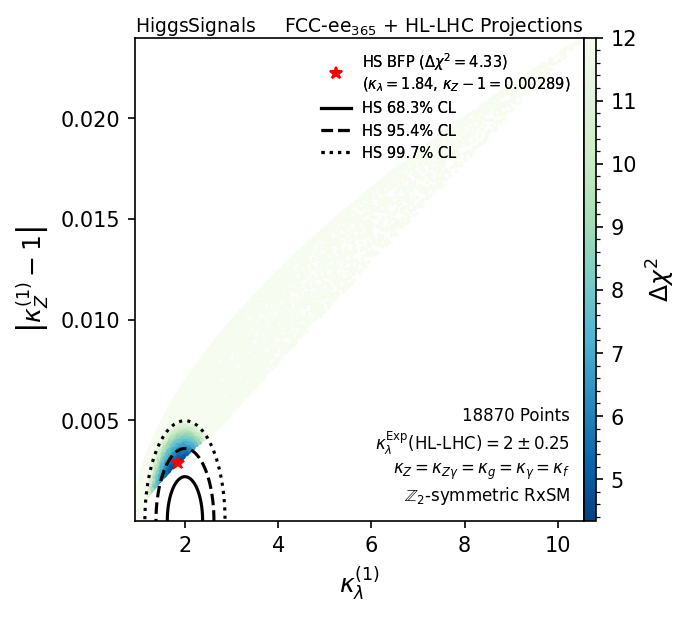

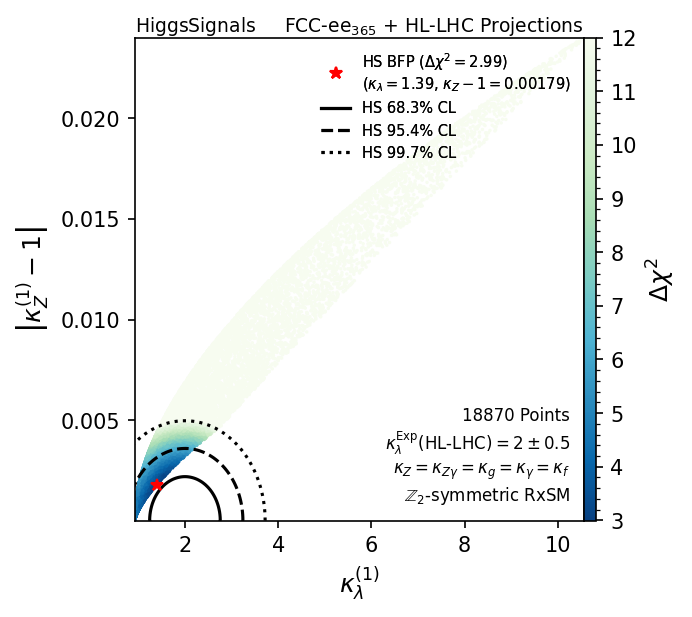

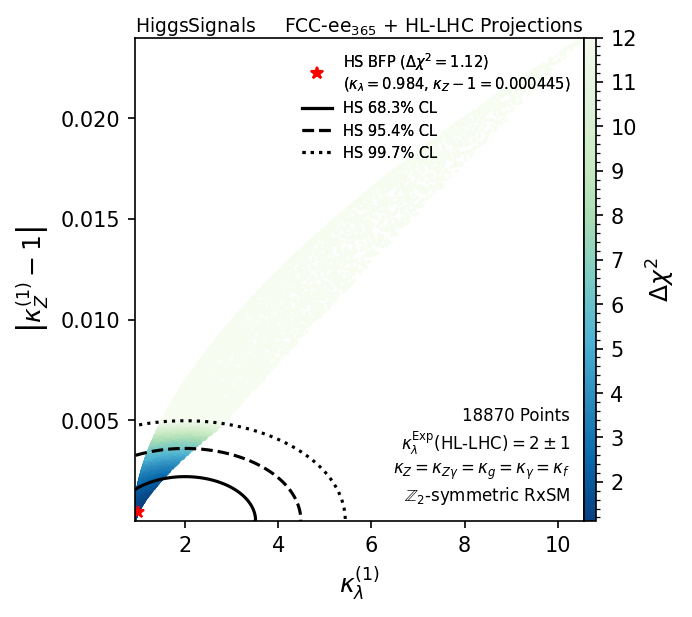

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_Z2_RxSM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error)

os.system("rm -rf modified_measurements")


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 2, (k_Z - 1) = 0.00329), with chisq = 5.16


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.99, (k_Z - 1) = 0.00321), with chisq = 4.98


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.97, (k_Z - 1) = 0.00316), with chisq = 4.81


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.84, (k_Z - 1) = 0.00289), with chisq = 4.33


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.39, (k_Z - 1) = 0.00179), with chisq = 2.99


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 0.984, (k_Z - 1) = 0.000445), with chisq = 1.12


0

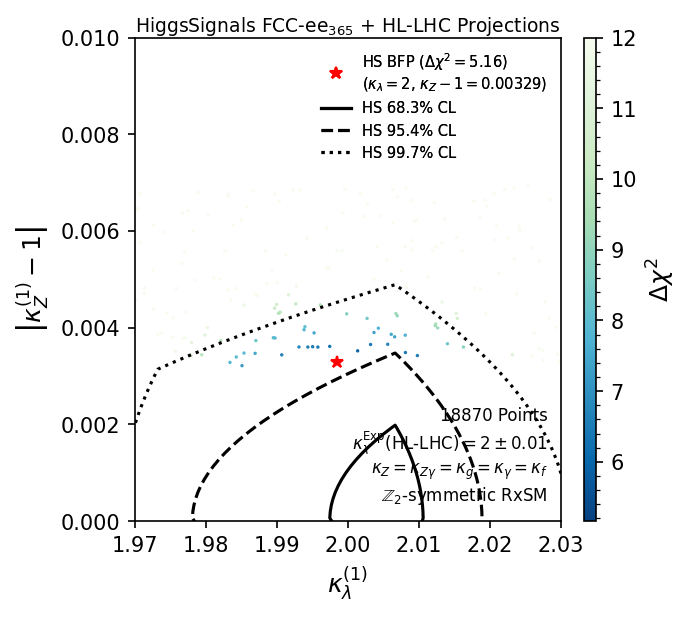

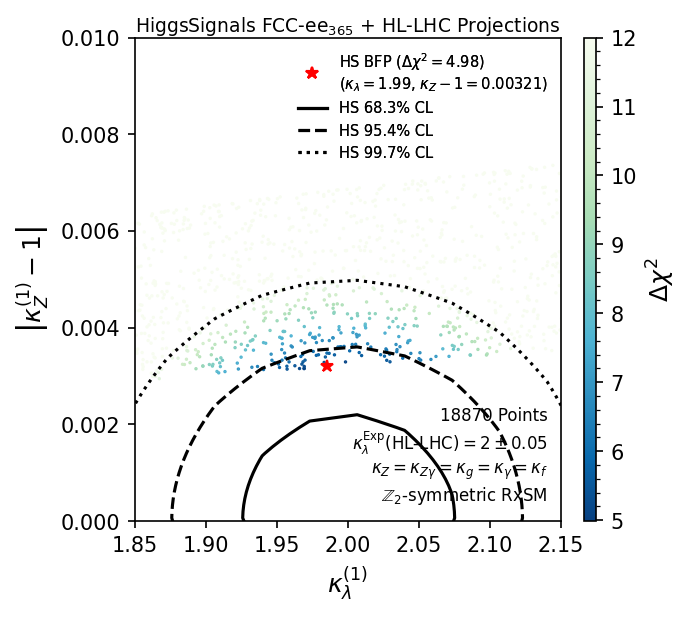

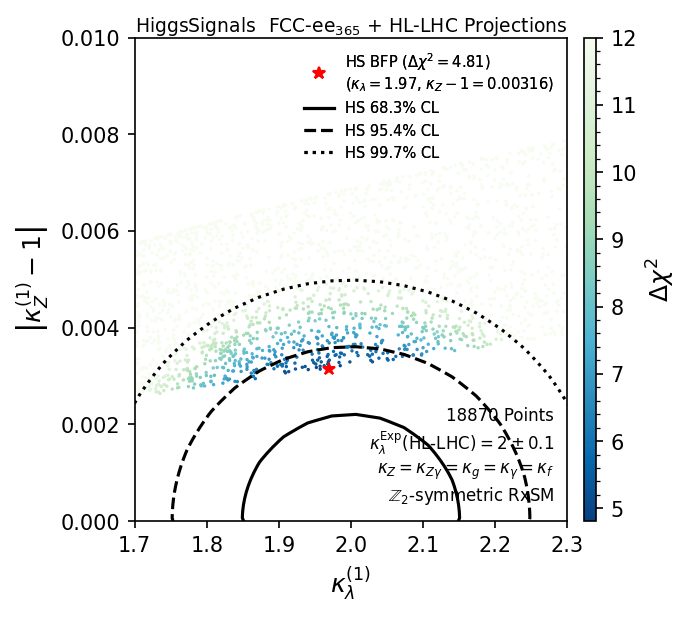

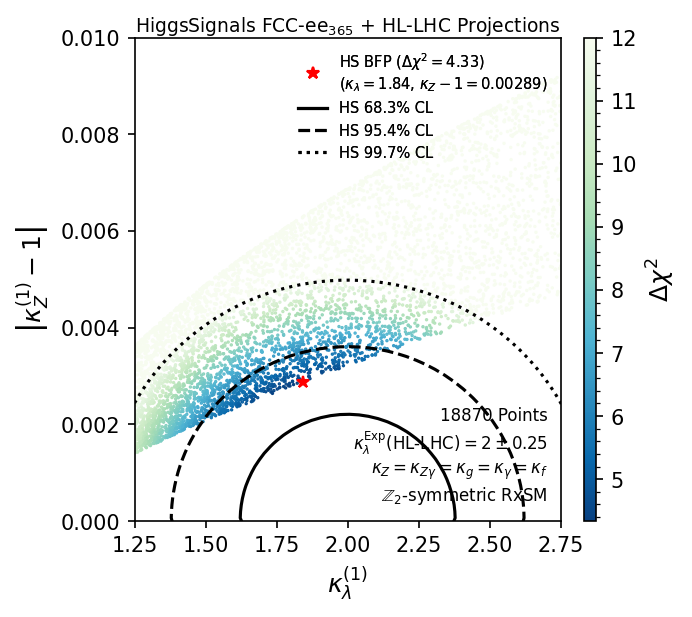

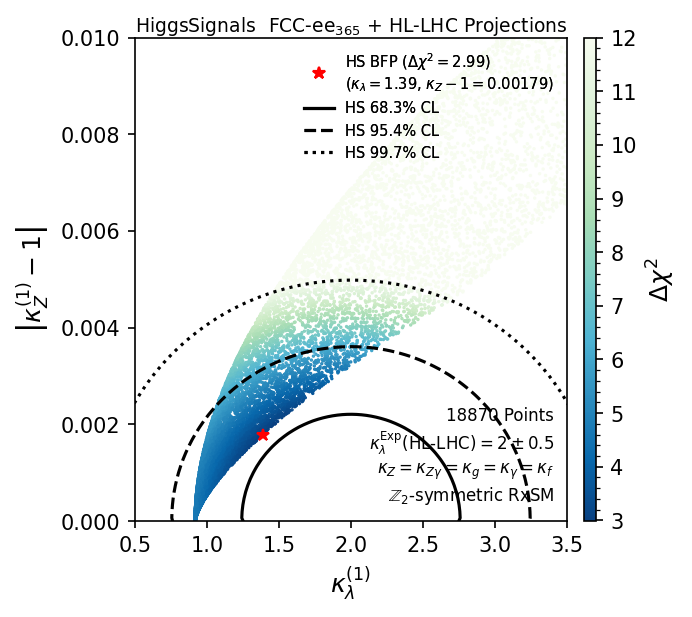

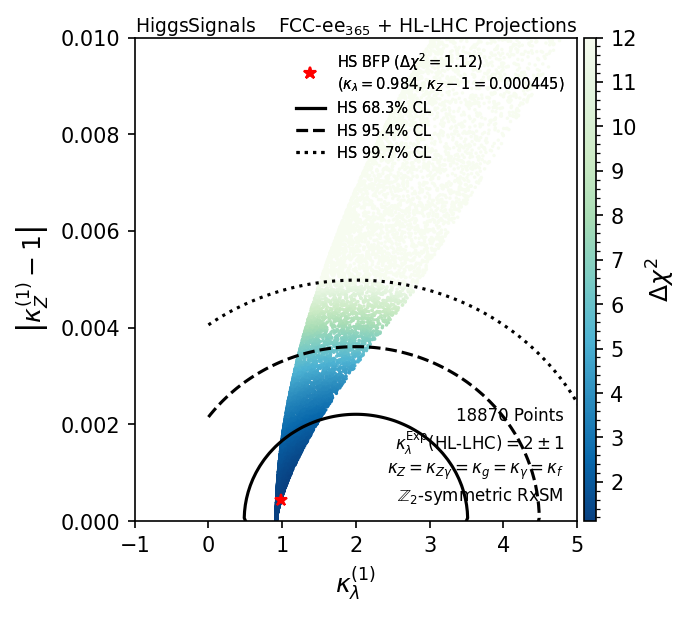

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_Z2_RxSM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error, zoom=True,
                        zoom_range_x=(2 - 3*k_lambda_exp_error, 2 + 3*k_lambda_exp_error))
    
os.system("rm -rf modified_measurements")

# New FCC-ee projections with obtained points

We take the kappa values obtained from the scans and use them as central values for the future projections for FCC-ee measurements, without any direct $\kappa_{\lambda}$ constraint from HL-LHC/ILC

#### Finding the more extreme benchmark point:

In [ ]:
full=True
datafile="data/Z2SSM/Z2_SSM_scan_fixed"
point_lam=2.48
df = pd.read_csv(data_file + ".csv") if not full else pd.read_csv(data_file + "_full_set.csv")

kappaLam2L = df['kappaLam2L']
kappaSingleHiggs2L = 1 - df['kappaSingleHiggs2L']
chisq = np.array([getChisq(row['kappaLam2L'], row['kappaSingleHiggs2L'], row["mS"], signals) for _, row in df.iterrows()])
for ind, row in df.iterrows():
    if row['kappaLam2L'] < 2.48: chisq[ind]=1e30

bfp_index = np.argmin(chisq)
bfp_chisq = np.min(chisq)
bfp = np.array([kappaLam2L[bfp_index], kappaSingleHiggs2L[bfp_index]])

print(f"Best scan point: (k_Lamb = {bfp[0]:.10g}, (1 - k_Z ) = {bfp[1]:.10g}), with chisq = {bfp_chisq:.3g}")
print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")
print(f"Best scan point model parameters: muS={df["muS"][bfp_index]}, lamS={df["lamS"][bfp_index]}, lamSH={df["lamSH"][bfp_index]}")

Best scan point: (k_Lamb = 2.482538926, (1 - k_Z ) = 0.004239875933), with chisq = 166
Best scan point row: 55671 out of 187416
Best scan point model parameters: muS=1764.0704455158084, lamS=-1.5476454185447963, lamSH=23.29248774323553


#### Changing the likelihood

In [11]:
# os.chdir("/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections")


def modify_kappa_central_values(kappas):
    
    os.system("mkdir modified_measurements")
    os.system("cp -r hsdataset/* modified_measurements/")
    os.chdir("modified_measurements/h125")
    os.system("rm EffLamHL-LHC_LHC13_LHCComb_6000.json")
    os.system("rm EffCouplings_FCCee365_FCCeeComb_1500.json")

    bins = {
        "effWW": {
            "coupling": "effWW",
            "obsCoupling": [kappas["WW"] - 0.41/100., kappas["WW"], kappas["WW"] + 0.41/100.],
            "process": {"channels": [[p, "WW"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effZZ": {
            "coupling": "effZZ",
            "obsCoupling": [kappas["ZZ"] - 0.17/100., kappas["ZZ"], kappas["ZZ"] + 0.17/100.],
            "process": {"channels": [[p, "ZZ"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effgg": {
            "coupling": "effgg",
            "obsCoupling": [kappas["gg"] - 0.9/100., kappas["gg"], kappas["gg"] + 0.9/100.],
            "process": {"channels": [[p, "gg"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effgamgam": {
            "coupling": "effgamgam",
            "obsCoupling": [kappas["gamgam"] - 1.3/100., kappas["gamgam"], kappas["gamgam"] + 1.3/100.],
            "process": {"channels": [[p, "gamgam"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effZgam": {
            "coupling": "effZgam",
            "obsCoupling": [kappas["Zgam"] - 10/100., kappas["Zgam"], kappas["Zgam"] + 10/100.],
            "process": {"channels": [[p, "Zgam"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effcc": {
            "coupling": "effcc",
            "obsCoupling": [kappas["cc"] - 1.3/100., kappas["cc"], kappas["cc"] + 1.3/100.],
            "process": {"channels": [[p, "cc"] for p in ("eeHZ", "eeHnunu")]},
        },
        "efftt": {
            "coupling": "efftt",
            "obsCoupling": [kappas["tt"] - 3.1/100., kappas["tt"], kappas["tt"] + 3.1/100.],
            "process": {"channels": [[p, "bb"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effbb": {
            "coupling": "effbb",
            "obsCoupling": [kappas["bb"] - 0.64/100., kappas["bb"], kappas["bb"] + 0.64/100.],
            "process": {"channels": [[p, "bb"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effmumu": {
            "coupling": "effmumu",
            "obsCoupling": [kappas["mumu"] - 3.9/100., kappas["mumu"], kappas["mumu"] + 3.9/100.],
            "process": {"channels": [[p, "mumu"] for p in ("eeHZ", "eeHnunu")]},
        },
        "efftautau": {
            "coupling": "efftautau",
            "obsCoupling": [kappas["tautau"] - 0.66/100., kappas["tautau"], kappas["tautau"] + 0.66/100.],
            "process": {"channels": [[p, "tautau"] for p in ("eeHZ", "eeHnunu")]},
        },
    }


    # Read correlation matrix from CSV file obtained from Fig. 14 through graphreader:
    corrMat = pd.DataFrame(
        index=bins.keys(), columns=bins.keys(), data=np.identity(len(bins))
    )

    corr_path = "EffCouplings_FCCee365_FCCeeComb_1500_correlations.csv"
    measurement_list = list(bins.keys())
    df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)
    for i, r in df.iterrows():
        for j in range(i+1, len(df.columns)):
            corrMat.loc[measurement_list[i], measurement_list[j]] = r[str(j)]

    # print(corrMat)

    measFile = implementMeasurement(
        "1905.03764",
        "Tab. 5, Fig. 14",
        bins,
        corrMatExp=corrMat,
        prefix="EffCouplings",
        referenceMass=125.38,
        massResolution=0.15 * 125,  # Change!
        experiment="FCCeeComb",
        collider="FCCee365",
        luminosity=1500
    )

    os.chdir("../..")

/jwd/tmp/ipykernel_1721/939526508.py:73: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)


Could not detect experiment
Looks good. Saving this to EffCouplings_FCCee365_FCCeeComb_1500.json
9
[np.float64(10.423363154355838), np.float64(17.21182898078949), np.float64(25.25686586179292)]
Best scan point: (k_Lamb = 1.279935964, (1 - k_Z ) = 0.002797079738), with chisq = -2.18e-05
Best scan point row: 198400 out of 203144
Best scan point model parameters: muS=487.04140136524177, lamS=4.339488870720752, lamSH=8.086139566881284
0.050925970701378165
Standard Model Chi2 value for kappa central values (k_Lamb = 1.801875586, (1 - k_Z ) = 0.002789967621): 3.344181119



/jwd/tmp/ipykernel_1721/939526508.py:73: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)


Could not detect experiment
Looks good. Saving this to EffCouplings_FCCee365_FCCeeComb_1500.json
9
[np.float64(10.423363154355838), np.float64(17.21182898078949), np.float64(25.25686586179292)]
Best scan point: (k_Lamb = 2.081304908, (1 - k_Z ) = 0.004232635842), with chisq = -2.26e-05
Best scan point row: 117951 out of 203144
Best scan point model parameters: muS=1149.7002499691434, lamS=7.948824580908525, lamSH=17.282034165448867
0.43292897330484803
Standard Model Chi2 value for kappa central values (k_Lamb = 2.482538926, (1 - k_Z ) = 0.004239875933): 7.67626483



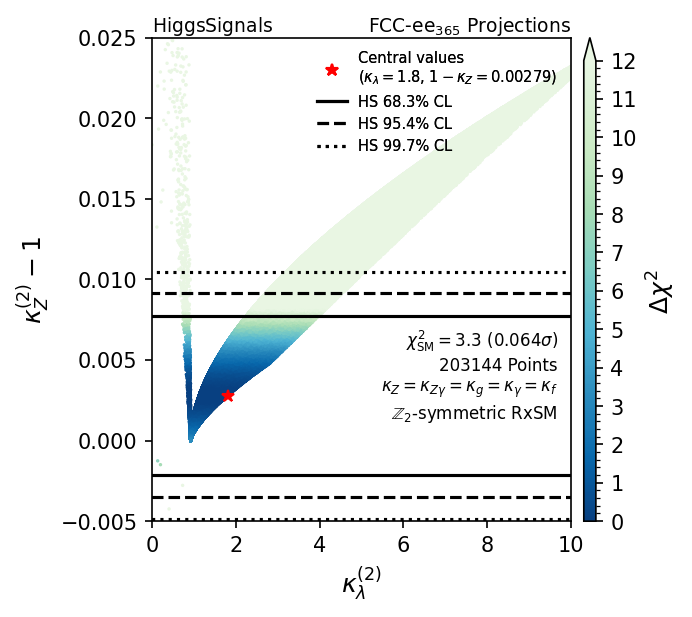

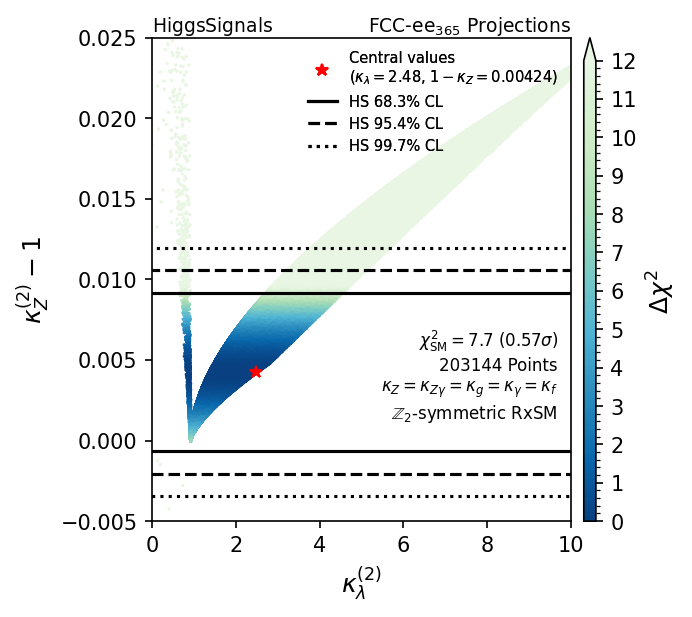

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan_fixed"
plot_dir = "plots"
points = [(1.801875586, 1 - 0.002789967621), (2.482538926, 1 - 0.004239875933)]
ndof = 10 - 1
# ndof = 1

kappas_list = {}
for point in points:
    kappas = dict()
    for kappa in ['WW', 'ZZ', 'gg', 'gamgam', 'Zgam', 'cc', 'tt', 'bb', 'mumu', 'tautau']:
        kappas[kappa] = point[1]
    kappas_list[point] = kappas

for point in points:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_central_values(kappas_list[point])

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    plot_Z2_RxSM_bounds(data_file, plot_dir, signals_mod, modified_central=point, 
                        ndof=ndof, full=True, zoom=True, zoom_range_x=(0, 10), zoom_range_y=(-0.005, 0.025))

    chisq_true = getChisq(*point, np.inf, signals_mod)
    chisq_SM = getChisq(1, 1, np.inf, signals_mod) - chisq_true
    print(f"Standard Model Chi2 value for kappa central values (k_Lamb = {point[0]:.10g}, (1 - k_Z ) = {1-point[1]:.10g}): {chisq_SM:.10g}\n")
    
    os.system("rm -rf modified_measurements")


In [29]:
os.system("rm -rf modified_measurements")

0

In [20]:
1-0.997210032379275

0.0027899676207250312